This notebook creates both the SFH and the SHAP maps for all the galaxies in the sample

# Importing Needed Modules

In [1]:
import numpy as np
import pandas as pd
import os, time, shutil, hickle
from tqdm import tqdm
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.8)
sns.set_style('white')
import hickle

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from PIL import Image as image_PIL
from PIL import Image, ImageOps
import PIL
from PIL import ImageShow
from astropy.io import fits

from zoobot.pytorch.estimators import define_model as ZoobotModel

import shap
import george 
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
running without emcee


In [2]:
work_dir = '#ONLY RUN IF USING CHAIN CONFIGUATION'

# Defining and Loading Saved Models

In [3]:
device = 'cuda'

model_used = 'ResNet50_log_t50_chain_90_10'
model_mass = models.resnet50(weights=None)
model_mass.fc = nn.Linear(2048, 1)
model_mass = nn.DataParallel(model_mass,device_ids=(0,1))
model_mass.load_state_dict(torch.load(work_dir+'models/Mass_'+model_used+'.pytorch'),strict=True)#strict is set to false since it was trained on multiple GPUs it causes an error when loaded on the model that is not on multiple GPUs yet
                                                                                                # DO NOT DO THIS!! MESSES WITH THE MODEL PREDECTIONS HEAVILY
model_mass.eval()

model_sfr = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_sfr.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,bias=False)
model_sfr.fc = nn.Linear(2048, 1)
model_sfr = nn.DataParallel(model_sfr,device_ids=(0,1))
model_sfr.load_state_dict(torch.load(work_dir+'models/SFR_'+model_used+'.pytorch'),strict=True)
model_sfr.eval()

model_used = 'd4000_chain'
model_t50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_t50.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,bias=False)
model_t50.fc = nn.Linear(2048, 1)
model_t50 = nn.DataParallel(model_t50,device_ids=(0,1))
model_t50.load_state_dict(torch.load(work_dir+'models/d4000_'+model_used+'.pytorch'),strict=True)
model_t50.eval()


model_mass, model_sfr, model_t50 = model_mass.to(device), model_sfr.to(device), model_t50.to(device)



For D4000 in non-chain configuration

In [ ]:
model_d4000 = models.resnet50(weights=None)
model_d4000.fc = nn.Linear(2048, 1)
model_d4000.load_state_dict(torch.load(work_dir+'models/d4000.pytorch'),strict=True)
model_d4000.to('cuda')
model_d4000.eval()

For SFR in non-chain configuration

In [ ]:
model_sfr_solo = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_sfr_solo.fc = nn.Linear(2048,1)
model_sfr_solo.load_state_dict(torch.load(work_dir+'models/sfr_solo.pytorch'),strict=True)


# Importing Data

Works for non-morphology dataloaders

In [10]:
def resize_image(src_image, size=(256,256), bg_color="black"): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

def load_image_data(idlist, size=(256,256), bg_color="black"):
    
    images = []
    for gal_id in tqdm(idlist):
        #img = plt.imread('images/'+gal_id+'.png')
        img = Image.open(work_dir+'images (DR17)/'+gal_id+'.png')
        img_sized = resize_image(img, size=size, bg_color=bg_color)
        images.append(img_sized)
    return images

class MaNGAdataset(Dataset):
    """images and labels for CNN"""
    
    def __init__(self, manga_cat, galmask, transform = None):
        
        gal_ids = manga_cat['manga_id']
        gal_ids = np.array(gal_ids,dtype=str)[galmask]
        gal_mass = manga_cat['log_mstar'][galmask]
        #gal_mass_scaled = (gal_mass - 9)/4
        gal_mass_scaled = gal_mass
        gal_sfr = manga_cat['log_sfr'][galmask]
        gal_z = manga_cat['redshift'][galmask]
        gal_n = manga_cat['sersic_n'][galmask]
        gal_t50 = np.log10(manga_cat['t50'])[galmask]
        gal_d4000 = manga_cat['d4000'][galmask]

        # good_index = np.where(gal_sfr != -np.inf)[0]
        good_index = np.where(np.array(gal_d4000,dtype=str) != 'nan')[0] #cleaning out nan values of d4000 

        gal_ids = gal_ids[good_index]
        gal_mass = gal_mass[good_index]
        gal_sfr = gal_sfr[good_index]
        gal_z = gal_z[good_index]
        gal_n = gal_n[good_index]
        gal_t50 = gal_t50[good_index]
        gal_d4000 = gal_d4000[good_index]

        ###########CLASSIC CLASSES#######################

        bars=np.linspace(np.min(gal_sfr), np.max(gal_sfr), num=11) #Number of classes set here (+1), default was 20 
        sfr_cat = np.zeros_like(gal_sfr)
        for i in range(len(bars)-1):
            sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)

        ########################NEW MORE EVENLY DISTRIBUTED CLASSES###################
        
        # bars=[-6,-2.5,-2,-1.7,-1.5,-1.2,-0.9,-0.7,-0.4,-0.1,0.1,0.9]
        # sfr_cat = np.zeros_like(gal_sfr)
        # for i in range(len(bars)-1):
        #     sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        # sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)
      
        self.image = load_image_data(gal_ids)
        self.mangaid = gal_ids
        self.mstar = gal_mass
        self.mstar_class = gal_mass
        self.sfr = sfr_cat
        self.z = gal_z
        self.n = gal_n
        #self.c = ((gal_mass - 6)*3 - 1).astype(int)
        self.c = sfr_cat.astype(int)
        self.transform = transform
        self.sfr_value = gal_sfr
        self.t50 = gal_t50
        self.d4000 = gal_d4000

        
    def __len__(self):
        return len(self.mstar)
    
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'image': self.image[idx],
                'mass': self.mstar[idx],
                'z':self.z[idx],
                'n':self.n[idx],
                'sfr_class':self.sfr[idx],
                'mangaid':self.mangaid[idx],
                'sfr':self.sfr_value[idx],
                't50':self.t50[idx],
                'd4000':self.d4000[idx]}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])

            
            
        return sample

In [ ]:
#Run this if you want both dataloaders to shuffle randomly everytime they are iterated
# train_loader = hickle.load(work_dir+'dataloaders/Train_Manga_DR17_log_t50_90_10')
# val_loader = hickle.load(work_dir+'dataloaders/Test_Manga_DR17_log_t50_90_10_SHUFFLE')

In [11]:
# train_loader = hickle.load(work_dir+'dataloaders/Train_Manga_DR17_d4000')
# val_loader = hickle.load(work_dir+'dataloaders/Test_Manga_DR17_d4000')


#Run this if you want both dataloaders to maintain the same order whenever they are iterated 
#d4000 loaders that have no transformations applied to the images when iterated 
train_loader = hickle.load(work_dir+'dataloaders/Train_Manga_DR17_d4000_NO_SHUFFLE')
val_loader = hickle.load(work_dir+'dataloaders/Test_Manga_DR17_d4000')


In [12]:
batch_size=32

val_ids=[]
mass=[]
sfr=[]
t50=[]
images=[]
z=[]
d4000=[]

data_sample=train_loader

for batch_idx, temp in enumerate(data_sample):
  val_ids.append(temp['mangaid'])
  mass.append(temp['mass'])
  sfr.append(temp['sfr'])
  t50.append(temp['t50'])
  images.append(temp['image'])
  z.append(temp['z'])
  d4000.append(temp['d4000'])


incomplete_batch_id=len(val_ids)-1

remainder=len(val_ids[incomplete_batch_id])

total_values=(len(val_ids)*batch_size)-(batch_size-remainder)



train_ids_list=[]
train_mass_list=[]
train_sfr_list=[]
train_t50_list=[]
train_images_list=[]
train_z_list=[]
train_d4000_list=[]
k=0
while k < total_values:
    for i in range(len(val_ids)):
        if i<incomplete_batch_id:
            for j in range(batch_size):
                train_ids_list.append(val_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_list.append(t50[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                train_d4000_list.append(d4000[i][j])
                k=k+1
        else:
            i=incomplete_batch_id
            for j in range(remainder):
                train_ids_list.append(val_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_list.append(t50[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                train_d4000_list.append(d4000[i][j])
                k=k+1

In [13]:
batch_size=32

val_ids=[]
mass=[]
sfr=[]
t50=[]
images=[]
z=[]
d4000=[]

data_sample=val_loader

for batch_idx, temp in enumerate(data_sample):
  val_ids.append(temp['mangaid'])
  mass.append(temp['mass'])
  sfr.append(temp['sfr'])
  t50.append(temp['t50'])
  images.append(temp['image'])
  z.append(temp['z'])
  d4000.append(temp['d4000'])


incomplete_batch_id=len(val_ids)-1

remainder=len(val_ids[incomplete_batch_id])

total_values=(len(val_ids)*batch_size)-(batch_size-remainder)



test_ids_list=[]
test_mass_list=[]
test_sfr_list=[]
test_t50_list=[]
test_images_list=[]
test_z_list=[]
test_d4000_list=[]
k=0
while k < total_values:
    for i in range(len(val_ids)):
        if i<incomplete_batch_id:
            for j in range(batch_size):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                test_t50_list.append(t50[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                test_d4000_list.append(d4000[i][j])
                k=k+1
        else:
            i=incomplete_batch_id
            for j in range(remainder):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                test_t50_list.append(t50[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                test_d4000_list.append(d4000[i][j])
                k=k+1

For Morpholgy Dataloders

In [5]:
def resize_image(src_image, size=(256,256), bg_color="black"): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

def load_image_data(idlist, size=(256,256), bg_color="black"):
    
    images = []
    for gal_id in tqdm(idlist):
        #img = plt.imread('images/'+gal_id+'.png')
        img = Image.open(work_dir+'images (DR17)/'+gal_id+'.png')
        img_sized = resize_image(img, size=size, bg_color=bg_color)
        images.append(img_sized)
    return images

class MaNGAdataset(Dataset):
    """images and labels for CNN"""
    
    def __init__(self, manga_cat, galmask, transform = None):
        
        gal_ids = manga_cat['manga_id']
        gal_ids = np.array(gal_ids,dtype=str)[galmask]
        gal_mass = manga_cat['log_mstar'][galmask]
        #gal_mass_scaled = (gal_mass - 9)/4
        gal_mass_scaled = gal_mass
        gal_sfr = manga_cat['log_sfr'][galmask]
        gal_z = manga_cat['redshift'][galmask]
        gal_n = manga_cat['sersic_n'][galmask]
        gal_t50_pipe3d = np.log10(manga_cat['t50_pipe3d'])[galmask]
        gal_t50_model = np.log10(manga_cat['t50_model'])[galmask]
        gal_d4000 = manga_cat['d4000'][galmask]
        gal_spirals = manga_cat['spirals'][galmask]
        gal_bars = manga_cat['bars'][galmask]
        gal_bulge = manga_cat['bulge'][galmask]
        gal_edge_on = manga_cat['edge_on'][galmask]
        gal_irregular_features = manga_cat['irregular_features'][galmask]

        # good_index = np.where(gal_sfr != -np.inf)[0]
        good_index = np.where(np.array(gal_d4000,dtype=str) != 'nan')[0] #cleaning out nan values of d4000 

        gal_ids = gal_ids[good_index]
        gal_mass = gal_mass[good_index]
        gal_sfr = gal_sfr[good_index]
        gal_z = gal_z[good_index]
        gal_n = gal_n[good_index]
        gal_t50_pipe3d = gal_t50_pipe3d[good_index]
        gal_t50_model = gal_t50_model[good_index]
        gal_d4000 = gal_d4000[good_index]
        gal_spirals = gal_spirals[good_index]
        gal_bulge = gal_bulge[good_index]
        gal_bars = gal_bars[good_index]
        gal_edge_on = gal_edge_on[good_index]
        gal_irregular_features = gal_irregular_features[good_index]


        ###########CLASSIC CLASSES#######################

        bars=np.linspace(np.min(gal_sfr), np.max(gal_sfr), num=11) #Number of classes set here (+1), default was 20 
        sfr_cat = np.zeros_like(gal_sfr)
        for i in range(len(bars)-1):
            sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)

        ########################NEW MORE EVENLY DISTRIBUTED CLASSES###################
        
        # bars=[-6,-2.5,-2,-1.7,-1.5,-1.2,-0.9,-0.7,-0.4,-0.1,0.1,0.9]
        # sfr_cat = np.zeros_like(gal_sfr)
        # for i in range(len(bars)-1):
        #     sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        # sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)
      
        self.image = load_image_data(gal_ids)
        self.mangaid = gal_ids
        self.mstar = gal_mass
        self.mstar_class = gal_mass
        self.sfr = sfr_cat
        self.z = gal_z
        self.n = gal_n
        #self.c = ((gal_mass - 6)*3 - 1).astype(int)
        self.c = sfr_cat.astype(int)
        self.transform = transform
        self.sfr_value = gal_sfr
        self.t50_pipe3d = gal_t50_pipe3d
        self.t50_model = gal_t50_model
        self.d4000 = gal_d4000
        self.spirals=gal_spirals
        self.bars = gal_bars
        self.bulge = gal_bulge
        self.edge_on = gal_edge_on
        self.irregular_features = gal_irregular_features

        
    def __len__(self):
        return len(self.mstar)
    
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'image': self.image[idx],
                'mass': self.mstar[idx],
                'z':self.z[idx],
                'n':self.n[idx],
                'sfr_class':self.sfr[idx],
                'mangaid':self.mangaid[idx],
                'sfr':self.sfr_value[idx],
                't50_pipe3d':self.t50_pipe3d[idx],
                't50_model':self.t50_model[idx],
                'd4000':self.d4000[idx],
                'spirals':self.spirals[idx],
                'bars':self.bars[idx],
                'bulge':self.bulge[idx],
                'edge_on':self.edge_on[idx],
                'irregular_features':self.irregular_features[idx]}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])

            
            
        return sample

In [6]:
train_loader = hickle.load(work_dir+'dataloaders/Train_Manga_DR17_Morph_for_SHAP_MAPS')
val_loader = hickle.load(work_dir+'dataloaders/Test_Manga_DR17_Morph_for_SHAP_MAPS')


In [7]:
batch_size = 32

train_ids = []
mass = []
sfr = []
t50_pipe3d = []
t50_model = []
images = []
z = []
d4000 = []
spirals = []
bars = []
bulge = []
edge_on = []
irregular_features = []

data_sample = train_loader

for batch_idx, temp in enumerate(data_sample):
    train_ids.append(temp['mangaid'])
    mass.append(temp['mass'])
    sfr.append(temp['sfr'])
    t50_pipe3d.append(temp['t50_pipe3d'])
    t50_model.append(temp['t50_model'])
    images.append(temp['image'])
    z.append(temp['z'])
    d4000.append(temp['d4000'])
    spirals.append(temp['spirals'])
    bars.append(temp['bars'])
    bulge.append(temp['bulge'])
    edge_on.append(temp['edge_on'])
    irregular_features.append(temp['irregular_features'])


incomplete_batch_id = len(train_ids) - 1
remainder = len(train_ids[incomplete_batch_id])

total_values = (len(train_ids) * batch_size) - (batch_size - remainder)

train_ids_list = []
train_mass_list = []
train_sfr_list = []
train_t50_pipe3d_list = []
train_t50_model_list = []
train_images_list = []
train_z_list = []
train_d4000_list = []
train_spirals_list = []
train_bars_list = []
train_bulge_list = []
train_edge_on_list = []
train_irregular_features_list = []

k = 0
while k < total_values:
    for i in range(len(train_ids)):
        if i < incomplete_batch_id:
            for j in range(batch_size):
                train_ids_list.append(train_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_pipe3d_list.append(t50_pipe3d[i][j])
                train_t50_model_list.append(t50_model[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                train_d4000_list.append(d4000[i][j])
                train_spirals_list.append(spirals[i][j])
                train_bars_list.append(bars[i][j])
                train_bulge_list.append(bulge[i][j])
                train_edge_on_list.append(edge_on[i][j])
                train_irregular_features_list.append(irregular_features[i][j])
                k += 1
        else:
            for j in range(remainder):
                train_ids_list.append(train_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_pipe3d_list.append(t50_pipe3d[i][j])
                train_t50_model_list.append(t50_model[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                train_d4000_list.append(d4000[i][j])
                train_spirals_list.append(spirals[i][j])
                train_bars_list.append(bars[i][j])
                train_bulge_list.append(bulge[i][j])
                train_edge_on_list.append(edge_on[i][j])
                train_irregular_features_list.append(irregular_features[i][j])
                k += 1


In [ ]:
for batch, temp in enumerate(train_loader):
    print(np.shape(temp['image']))

In [9]:
batch_size = 32

val_ids = []
mass = []
sfr = []
t50_pipe3d = []
t50_model = []
images = []
z = []
d4000 = []
spirals = []
bars = []
bulge = []
edge_on = []
irregular_features = []

data_sample = val_loader

for batch_idx, temp in enumerate(data_sample):
    val_ids.append(temp['mangaid'])
    mass.append(temp['mass'])
    sfr.append(temp['sfr'])
    t50_pipe3d.append(temp['t50_pipe3d'])
    t50_model.append(temp['t50_model'])
    images.append(temp['image'])
    z.append(temp['z'])
    d4000.append(temp['d4000'])
    spirals.append(temp['spirals'])
    bars.append(temp['bars'])
    bulge.append(temp['bulge'])
    edge_on.append(temp['edge_on'])
    irregular_features.append(temp['irregular_features'])


incomplete_batch_id = len(val_ids) - 1
remainder = len(val_ids[incomplete_batch_id])

total_values = (len(val_ids) * batch_size) - (batch_size - remainder)

test_ids_list = []
test_mass_list = []
test_sfr_list = []
test_t50_pipe3d_list = []
test_t50_model_list = []
test_images_list = []
test_z_list = []
test_d4000_list = []
test_spirals_list = []
test_bars_list = []
test_bulge_list = []
test_edge_on_list = []
test_irregular_features_list = []

k = 0
while k < total_values:
    for i in range(len(val_ids)):
        if i < incomplete_batch_id:
            for j in range(batch_size):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                test_t50_pipe3d_list.append(t50_pipe3d[i][j])
                test_t50_model_list.append(t50_model[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                test_d4000_list.append(d4000[i][j])
                test_spirals_list.append(spirals[i][j])
                test_bars_list.append(bars[i][j])
                test_bulge_list.append(bulge[i][j])
                test_edge_on_list.append(edge_on[i][j])
                test_irregular_features_list.append(irregular_features[i][j])
                k += 1
        else:
            for j in range(remainder):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                test_t50_pipe3d_list.append(t50_pipe3d[i][j])
                test_t50_model_list.append(t50_model[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                test_d4000_list.append(d4000[i][j])
                test_spirals_list.append(spirals[i][j])
                test_bars_list.append(bars[i][j])
                test_bulge_list.append(bulge[i][j])
                test_edge_on_list.append(edge_on[i][j])
                test_irregular_features_list.append(irregular_features[i][j])
                k += 1


Getting t50 values from d4000 to t50 model

In [16]:
#Logged to be put into the same units as the t50 from Pipe3D (BUT NOT IN LOOKBACK TIME)
train_t50_list = np.log10(np.load('/home/juanpabloalfonzo/Documents/Manga CNNs/Simulated Data/t50_outputs_train.npy')*13.6)
test_t50_list = np.log10(np.load('/home/juanpabloalfonzo/Documents/Manga CNNs/Simulated Data/t50_outputs_test.npy')*13.6)

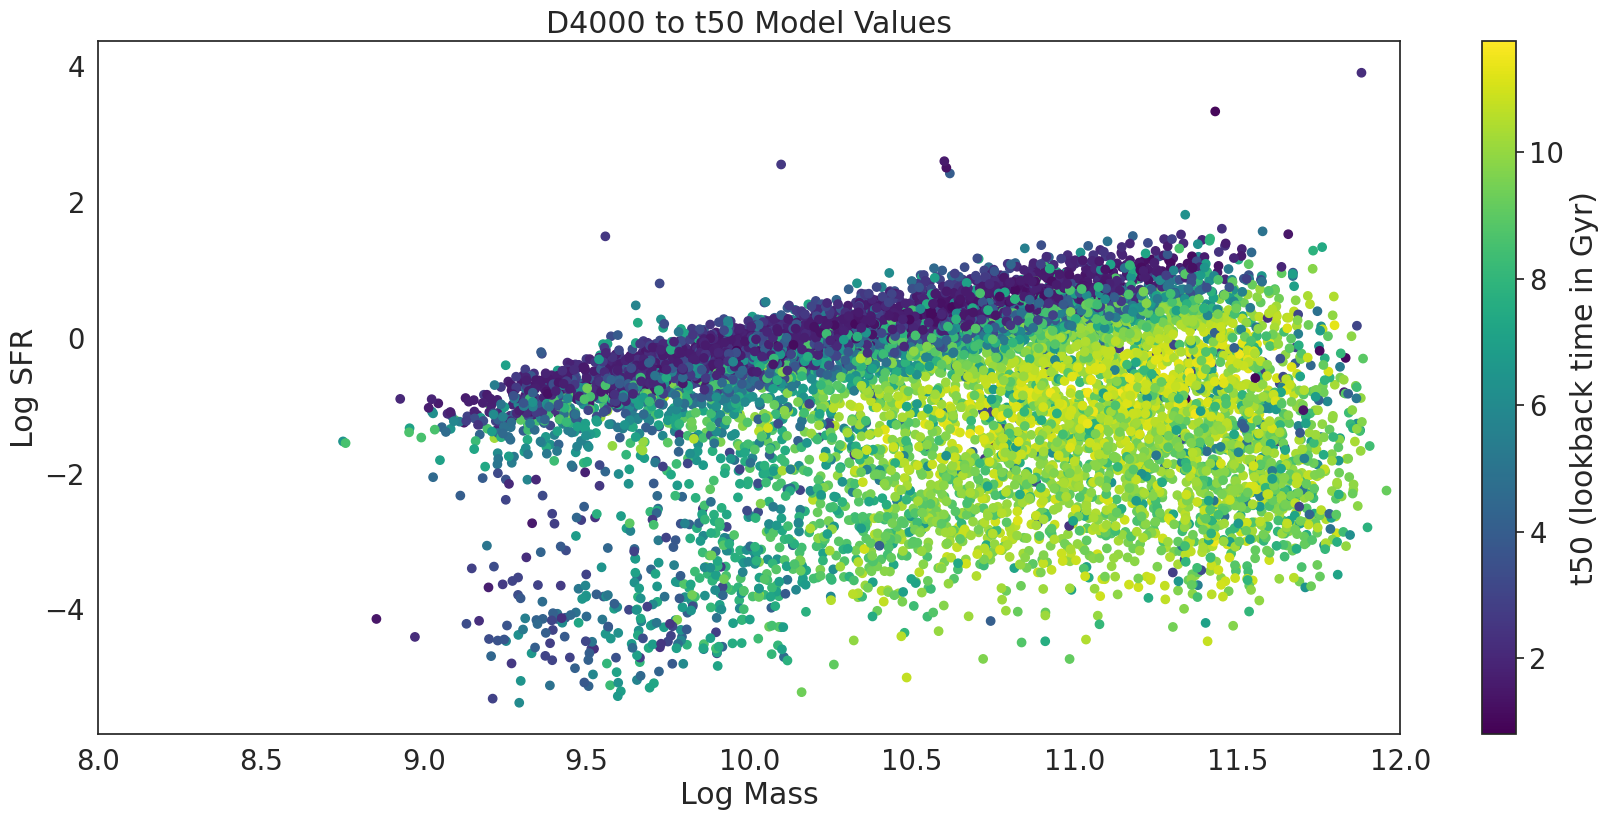

In [11]:
physical_index = np.where(10**np.array(train_t50_model_list) < 13.6)[0]

plt.figure(figsize=(21,9))
plt.scatter(np.array(train_mass_list)[physical_index],np.array(train_sfr_list)[physical_index],c=np.abs(10**np.array(train_t50_model_list)[physical_index]-13.6),cmap='viridis')
# plt.scatter(test_mass_list,test_sfr_list,c=10**np.array(test_t50_model_list),cmap='viridis')
plt.title('D4000 to t50 Model Values')
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.xlim(8,12)
# plt.ylim(-16,-8)
plt.colorbar(label='t50 (lookback time in Gyr)')

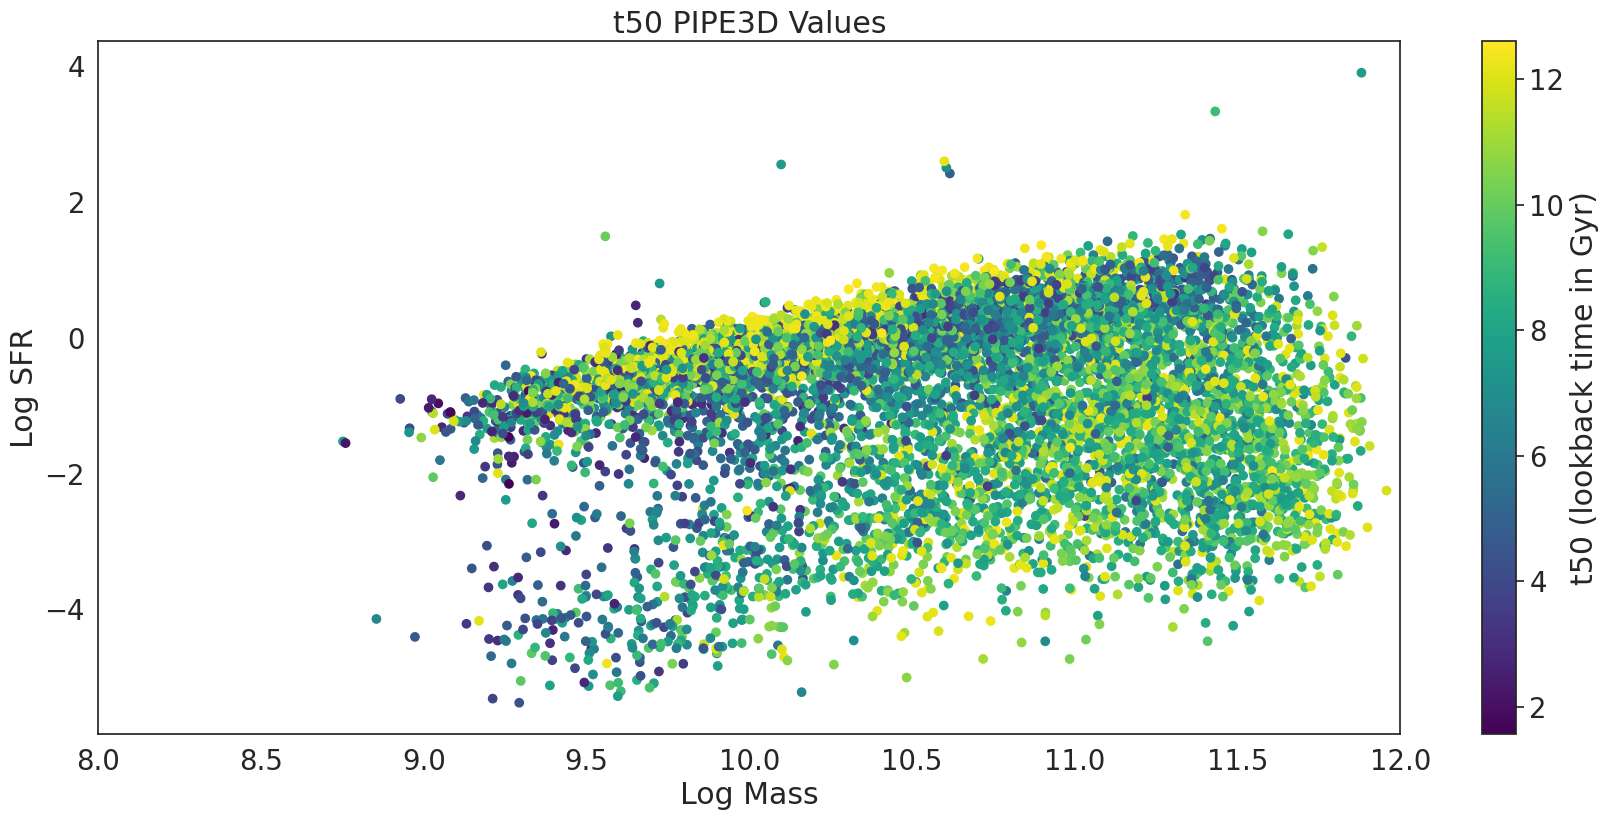

In [12]:
plt.figure(figsize=(21,9))
plt.title('t50 PIPE3D Values')
plt.scatter(train_mass_list,np.array(train_sfr_list),c=10**np.array(train_t50_pipe3d_list),cmap='viridis')
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.xlim(8,12)
# plt.ylim(-16,-8)
plt.colorbar(label='t50 (lookback time in Gyr)')

# SFH + XAI Plots

Generating SFH from dense_basis

In [10]:
import george 
import dense_basis as db

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
running without emcee


In [17]:
def sfh_true(mass,sfr,t50,z,mangaids,data_set): 

    mass = np.array(mass)
    sfr = np.array(sfr)
    mangaids = np.array(mangaids,dtype=str)
    z = np.array(z)
    t50= np.array(t50)
    # n = np.array(n)

    common_time = np.linspace(0, db.cosmo.age(np.min(z)).value, 1000)

    common_sfhs = np.zeros((len(common_time), len(mangaids)))
    common_sfhs_normalized = np.zeros((len(common_time), len(mangaids)))


  # log stellar mass, log SFR, Nparam, {tx] - in t_50 in Gyr / age of the universe
    for i in tqdm (range(len(mass))):
      sfh_tuple = np.array([mass[i], sfr[i], 1.0, 10**(t50[i])/db.cosmo.age(z[i]).value])

      sfh, timeax = db.tuple_to_sfh(sfh_tuple, z[i])
      
      common_sfhs[:,i] = np.interp(common_time, timeax, sfh)

      norm_fac = np.trapz(x = common_time, y = common_sfhs[:,i])
      common_sfhs_normalized[:,i] = common_sfhs[:,i] / norm_fac

      temp = np.array([timeax,sfh])

      x_loc = np.min(timeax)
      y_loc = np.max(sfh)

      plt.figure(figsize=(21,9))
      # plt.plot(timeax, sfh)
      db.plot_sfh(timeax,sfh)
      plt.xlabel('t [Gyr]')
      plt.ylabel('SFR(t) [Msun/yr]')
      plt.text(x_loc,y_loc,'Redshift:'+str(z[i])[:4],size='x-small')
      plt.text(x_loc,y_loc-(y_loc/8),'Log Stellar Mass:'+str(mass[i])[:4],size='x-small')
      plt.text(x_loc,y_loc-(y_loc/4),'Log SFR:'+str(sfr[i])[:4],size='x-small')
      plt.text(x_loc,y_loc-(y_loc/2),'Log t50:'+str(t50[i])[:4],size='x-small')
      # plt.text(x_loc,y_loc- (y_loc/2),'Sersic Index:'+str(n[i]))
      plt.close('all')


Creating Plots

In [8]:
def indv_sfh(data_set,mangaid):
  temp1= hickle.load(work_dir+'Catalogues/manga_scalars')
  temp = temp1['sfh']
  
  times=temp[0]
  sfhs=temp[1]

  sfhs[(sfhs==0)] = 1e-4

  return(times,sfhs)


In [284]:
def Shap_SFH_Plots_specific(data_loader,model,data_set,batch_index,index):
    device = 'cuda'
    global model_mass
    global model_sfr
    global model_t50
    global model_d4000
    global batch_size

    x_loc=0
    y_loc=15

    for batch_idx, temp in enumerate(data_loader):
        if batch_idx == batch_index:
            image_batch = temp['image'].to(device)
            # selected_image = image_batch[:index]
            selected_image_display = image_batch[index-1,:,:,:]
            mangaid = temp['mangaid'][index-1]
            mass = temp['mass'][index-1]
            sfr = temp['sfr'][index-1]
            d4000 = temp['d4000'][index-1]
            selected_image = image_batch[:index]
        

    timeax , sfh = indv_sfh(data_set,str(mangaid))
    
    db.plot_sfh(timeax,sfh,lookback=True)
    
    if model == model_mass or model == model_d4000 or model == model_sfr_solo:
        
        model=model.to(device)

        e = shap.GradientExplainer(model,image_batch)

        shap_values= e.shap_values(selected_image)

        # plot the explanations

        shap_numpy = list(np.array(shap_values).transpose(0,2,3,1))
        display_images = selected_image_display.detach().cpu().numpy().transpose(1,2,0)
        # print(np.shape(shap_numpy),np.shape(display_images))
       
        # if index == 0:
        #     shap.image_plot(shap_numpy[-1],display_images,labels=None,show=False)
        # else:

        # np.save('/home/juanpabloalfonzo/Documents/Manga CNNs/SHAP-Maps/'+str(target)+'/'+str(data_set)+'/'+str(mangaid),shap_numpy[index-1])    
        shap.image_plot(shap_numpy[index-1],display_images,labels=None,show=False)
        plt.text(x_loc,y_loc,'Manga-ID:'+str(np.array(mangaid)),fontsize=10,color='black')
        plt.text(x_loc,y_loc+20,'Log $M_\odot$:'+str(np.array(mass))[0:6],fontsize=10,color='black')
        plt.text(x_loc,y_loc+40,'Log SFR:'+str(np.array(sfr))[0:6],fontsize=10,color='black')
        plt.text(x_loc,y_loc+60,'d4000:'+str(np.array(d4000))[0:6],fontsize=10,color='black')
        plt.show()

    else:
        print('Please use a supported model')
    
    




# SHAP Plot Maker

In [ ]:
Shap_SFH_Plots_specific(val_loader,model_sfr_solo,'Test',batch_index=5,index=1)
